# AI Agent Bhorali

In [1]:
from typing import Annotated, List
from typing_extensions import TypedDict
from IPython.display import Image

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt.chat_agent_executor import AgentState
import requests
from pydantic import BaseModel, Field


In [5]:
# model = ChatOpenAI(model="gpt-4o", temperature=0)

# # pydantic
# class PersonSchema(BaseModel):
#     """Details of the person"""

#     name: str = Field(description="Name of the person")
#     age: int = Field(description="age in years of the person")
#     height: float = Field(description="height in feet and inch")
#     wives: list[str] = Field(description="list of names of the present and past wives")
#     news: list[str] = Field(description="list of what the person did interesting in the last week, with dates provided.")


# structured_llm = model.with_structured_output(PersonSchema)

# structured_llm.invoke("tell me about Diana")

In [35]:
class State(TypedDict):
    task: str 
    coins_to_invest: list[str]
    coins_risk_assessed: list[str]

def get_top_dexscreener_coins():
    '''Get the top 30 tokens on dexscreener'''
    chain_id = "solana"

    # Get the tokens with most active boosts on dexscreener (rate-limit 60 requests per minute)
    response = requests.get(
        "https://api.dexscreener.com/token-boosts/top/v1",
        headers={},
    )
        
    data = response.json()

    # Extract token addresses from the response data
    token_addresses = [item["tokenAddress"] for item in data if item["chainId"] == chain_id]

    response = requests.get(
        f"https://api.dexscreener.com/tokens/v1/{chain_id}/{','.join(token_addresses)}",
        headers={},
    )

    data = response.json()
    
    # return Command(
    #     update = {
    #         "messages": [
    #             ToolMessage(f'Successfully fetched top 30 tokens on dexscreener, {data}', tool_call_id=tool_call_id)
    #         ]
    #     }
    # )

    return f'Top 30 tokens on dexscreener: {data}'


search_tool = TavilySearchResults(max_results=2)

system_prompt = "You are a DEX Trading Analysis AI specializing in identifying short-term cryptocurrency opportunities." 

coins_prompt = """Analyze DEXScreener data and filter out the high-potential tokens (maximum 10) by examining price action, volume, liquidity, and holder patterns. 
For each recommendation, provide: token details (address, chain, price), key metrics (market cap, volume, liquidity)."""

risk_assessment_prompt = """ 
                         Asses the contract safety, team verification, potential red flags for the safe tokens and filter out the high risk tokens.
                         Output the list of safe tokens.
                         Never recommend tokens with suspicious contracts or extremely low liquidity."""


In [39]:
class Agent:

    def __init__(self, model):
        graph_builder = StateGraph(State)
        self.llm = model
        # self.llm = model.bind_tools(tools)

        # set_llm_cache(SQLiteCache(database_path=".langchain.db"))
        # memory = SqliteSaver.from_conn_string(":memory:")
        memory = MemorySaver()

        # tool_node = ToolNode(tools)

        graph_builder.add_node("get_coins", self.get_coins_node)
        graph_builder.add_node("get_risk_assessment", self.get_risk_assessment_node)

        graph_builder.add_edge(START, "get_coins")
        graph_builder.add_edge("get_coins", "get_risk_assessment")
        graph_builder.add_edge("get_risk_assessment", END)
        
        self.graph = graph_builder.compile(checkpointer=memory)

    
    def get_coins_node(self, state: State):
        dexscreener_coins = get_top_dexscreener_coins()
        messages = [
            SystemMessage(content=system_prompt),
            SystemMessage(content=coins_prompt),
            HumanMessage(content=state['task']),
            AIMessage(content=dexscreener_coins),
        ]

        response = self.llm.invoke(messages)

        return {"coins_to_invest": response.content}
    
    def get_risk_assessment_node(self, state: State):
        messages = [
            SystemMessage(content=risk_assessment_prompt),
            HumanMessage(content=state["coins_to_invest"]),
        ]

        response = self.llm.invoke(messages)

        return {"coins_risk_assessed": response.content}
        
    
    def show_graph(self):
        return Image(self.graph.get_graph().draw_mermaid_png())
    
    def stream_graph_updates(self, config, user_input: str):
        for event in self.graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values",
        ):
            # for value in event.values():
            event["messages"][-1].pretty_print()

    def route_tools(self, state: State):
        print("Previous State", state)
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get("messages", []):
            ai_message = messages[-1]
        else:
            raise ValueError("No AI messages found in input state: {state}")

        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"
        return "get_risk_assessment"

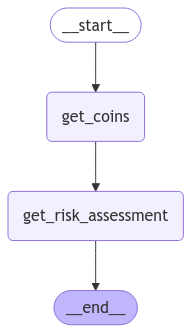

In [40]:
model = ChatOpenAI(model="gpt-4o", temperature=0)
# tools = [get_top_dexscreener_coins, search_tool]
agent = Agent(model)

agent.show_graph()

In [41]:
thread = {"configurable": {"thread_id": "1"}}

# events = agent.graph.stream(
#     {"task": "get me coins to BUY"},
#     thread,
#     stream_mode="values",
# )

# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

for s in agent.graph.stream({
    'task': "get me coins to BUY",
}, thread):
    (print(s))

{'get_coins': {'coins_to_invest': 'Based on the DEXScreener data, here are some high-potential tokens to consider for short-term trading opportunities. These tokens have been selected based on their price action, volume, liquidity, and market cap:\n\n1. **MMUSK (Solana)**\n   - **Address:** 8csPcR1juDwvcJX1Uji4qT8WE6ExHSCw9G7zDraQpump\n   - **Price:** $0.0002743\n   - **Market Cap:** $274,360\n   - **Volume (24h):** $2,611,476.97\n   - **Liquidity:** $65,980.08\n\n2. **Deep Bober (Solana)**\n   - **Address:** BoBerxDHjePJSn4nVEnnEQyYtHZY3kGTea6jtqLq8gTj\n   - **Price:** $0.07665\n   - **Market Cap:** $76,652,348\n   - **Volume (24h):** $31,571,213.63\n   - **Liquidity:** $6,885,987.4\n\n3. **Marsh Coin (Solana)**\n   - **Address:** jUfwXi6BWechD13bzp1R1h2AR3bSKuGkJd5qJmppump\n   - **Price:** $0.0001593\n   - **Market Cap:** $159,350\n   - **Volume (24h):** $5,723,195.32\n   - **Liquidity:** $57,141.8\n\n4. **SUPERBOWL LIX (Solana)**\n   - **Address:** 2ychLEgnyMqfSrX85n5qiuA5BgrNsovsmN